In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchmetrics.functional import regression
from torchmetrics.regression import R2Score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optimizer
from torch.nn import functional as F
from torchinfo import summary
from func import Torch_preccesing


In [21]:
# 데이터
File='../data/boston.csv'
boston_DF= pd.read_csv(File)
boston_DF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [22]:
boston_TS=Torch_preccesing(boston_DF)

In [23]:
boston_TS.feature=boston_DF[boston_DF.columns[:-1]]
boston_TS.feature.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03


In [24]:
boston_TS.target=boston_DF['MEDV']

In [25]:
# 분리
boston_TS.split()

train: (284, 13),(284,)
test: (127, 13),(127,)
val: (95, 13),(95,)


In [26]:
# 스케일링
mmscaler= MinMaxScaler()
mmscaler.fit(boston_TS.X_train)

MinMaxScaler()

In [27]:
X_train_scaled=mmscaler.transform(boston_TS.X_train)
X_test_scaled= mmscaler.transform(boston_TS.X_test)
X_val_scaled= mmscaler.transform(boston_TS.X_val)

In [28]:
# 모델 준비
# - 모델 설계
# 알고리즘: 선형 관계
# 피쳐 수:13
# 타겟 수:1
# ==> 입력층: 입력(3), 퍼셉트론(10), AF(ReLU)
#     은닉층: 입력(10), 퍼셉트론(10), AF(ReLU)*10번
#     출력층: 입력(10), 퍼셉트론(1), AF

model=nn.Sequential(nn.Linear(13,10),
                    nn.ReLU(),
                    nn.Linear(10,10),
                    nn.ReLU(),
                    nn.Linear(10,10),
                    nn.ReLU(),
                    nn.Linear(10,1)
                    )

In [29]:
# 모델 구조 확인
print(model)
summary(model, input_size=(13,))  #input_size는 (피쳐수,)

Sequential(
  (0): Linear(in_features=13, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1]                       --
├─Linear: 1-1                            [10]                      140
├─ReLU: 1-2                              [10]                      --
├─Linear: 1-3                            [10]                      110
├─ReLU: 1-4                              [10]                      --
├─Linear: 1-5                            [10]                      110
├─ReLU: 1-6                              [10]                      --
├─Linear: 1-7                            [1]                       11
Total params: 371
Trainable params: 371
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [30]:
for name, param in model.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([[ 0.2541,  0.1284, -0.0649, -0.0691, -0.1078,  0.1398, -0.1399,  0.0775,
          0.1570,  0.2619,  0.1318,  0.1650,  0.1014],
        [ 0.2498, -0.0622, -0.0689, -0.0988, -0.1289, -0.0704, -0.0501, -0.0961,
         -0.0586, -0.1345,  0.0952, -0.2303, -0.0558],
        [-0.0605,  0.1378,  0.0998, -0.1941,  0.2554, -0.1156,  0.1689,  0.2316,
          0.2474,  0.2665, -0.0752,  0.2734, -0.0812],
        [ 0.0286,  0.0876, -0.2416,  0.0286, -0.2667, -0.0283,  0.2428,  0.1839,
          0.0488,  0.1413, -0.1702, -0.2768, -0.0607],
        [-0.0883,  0.1549,  0.0864,  0.1799, -0.1924,  0.1057, -0.1468, -0.1287,
         -0.1631, -0.2521,  0.0593,  0.0413, -0.0620],
        [-0.1430,  0.1225,  0.0386, -0.1914,  0.0665, -0.1801, -0.2618,  0.2391,
         -0.0150,  0.2380,  0.1878, -0.1603,  0.2563],
        [ 0.0625, -0.1527,  0.1961, -0.0396, -0.1858,  0.0871,  0.1074, -0.0557,
          0.2581, -0.2193, -0.1280, -0.1268,  0.1989],
        [ 0.0935,

In [31]:
# 모델 최적화 인스턴스 전달
adam_optim=optimizer.Adam(model.parameters(), lr=0.1)

In [32]:
# 학습 진행
# - 배치, 에포크, 디바이스 결정
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
EPOCH=100
BACH_SIZE=10
BACH_CNT=boston_TS.X_train.shape[0]//BACH_SIZE
print(EPOCH, BACH_SIZE, BACH_CNT)

100 10 28


In [33]:
# 검증 함수
def testing(model, X_val, Y_val, kind='Val'):
    # tensor화
    bsX_val= torch.FloatTensor(X_val.values).to(DEVICE)
    bsY_val= torch.FloatTensor(Y_val.values).reshape(-1,1).to(DEVICE)

    with torch.no_grad():   #가중치 및 절편 업데이트 진행 X
        # (1) 학습진행  forward(순전파)
        # - 먼저 shape과 dtype이 동일한지 확인을 위해 실행해보기!!
        pre_y= model(bsX_val)

        # (2) 오차계산 - 손실함수
        loss=F.mse_loss(pre_y, bsY_val)
        
        # (3) 성능평가 - r2
        r2=R2Score()(pre_y, bsY_val)
         
        # (5) 학습결과 출력 및 저장
        print(f'[{kind}] LOSS: {loss}, R2: {r2}')
        return loss, r2

In [34]:
X_train_scaled[:3]

array([[0.00735279, 0.        , 0.34604106, 0.        , 0.32716049,
        0.41712426, 0.82032086, 0.26039401, 0.13043478, 0.22328244,
        0.61702128, 0.98427912, 0.4580574 ],
       [0.00728198, 0.        , 0.21041056, 0.        , 0.24485597,
        0.89546471, 0.76791444, 0.15991628, 0.30434783, 0.22900763,
        0.5106383 , 0.96995284, 0.0665011 ],
       [0.15718567, 0.        , 0.64662757, 1.        , 0.50617284,
        0.64124466, 0.97326203, 0.00595114, 1.        , 0.91412214,
        0.80851064, 0.98770222, 0.0339404 ]])

In [35]:
# 학습 진행
def training(X_train, Y_train, X_val, Y_val):
    EPOCH=100
    BATCH_SIZE=12
    BATCH_CNT= X_train.shape[0]//BATCH_SIZE
                # T   V
    loss_history=[[],[]]
    r2_history= [[],[]]
    for epch in range(1,EPOCH+1):
        # 배치 손실 저장 변수
        bs_loss, bs_r2=0,0
        # 배치 크기 만큼 학습
        for i in range(BATCH_CNT):
            start= i*BATCH_SIZE
            end= start+ BATCH_SIZE
            print(start, end)
            # BS크기 만큼만 데이터 추출해서 Tensor화 진행
            BSX_train= torch.FloatTensor(X_train[start:end].values).to(DEVICE)
            BSY_train= torch.FloatTensor(Y_train[start:end].values).reshape(-1,1).to(DEVICE)
            print(BSX_train.shape, BSX_train.device, BSX_train.dtype)
            print(BSY_train.shape, BSY_train.device, BSY_train.dtype)


            pre_y= model(BSX_train)
            print(pre_y.shape)

            # (2) 오차계산 - 손실함수
            loss=F.mse_loss(pre_y, BSY_train)
            bs_loss+= loss.item()
            bs_r2 +=R2Score()(pre_y, BSY_train).item()

            # (3) 최적화 - 가중치, 절편 업데이트 backward(역전파)
            # - 가중치 초기화 -> 가중치 계산 -> 가중치 적용
            adam_optim.zero_grad()
            loss.backward()
            adam_optim.step()

        # (4)검증
        val_loss, val_r2=testing(model, X_val, Y_val)
        loss_history[1].append(val_loss.item())
        r2_history[1].append(val_r2.item())

        loss_history[0].append(bs_loss/BATCH_CNT)
        r2_history[0].append(bs_r2/BATCH_CNT)
        # (5) 학습결과 출력 및 저장
        print(f'[{epch}/{EPOCH}] \nTrain => LOSS: {loss_history[0][-1]}\nR2: {r2_history[0][-1]}')
        print(f'VAL => LOSS: {loss_history[1][-1]}\nR2: {r2_history[1][-1]}')
    return loss_history, r2_history

In [36]:
loss, r2= training(boston_TS.X_train, boston_TS.Y_train, boston_TS.X_val, boston_TS.Y_val)

0 12
torch.Size([12, 13]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
12 24
torch.Size([12, 13]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
24 36
torch.Size([12, 13]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
36 48
torch.Size([12, 13]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
48 60
torch.Size([12, 13]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
60 72
torch.Size([12, 13]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
72 84
torch.Size([12, 13]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
84 96
torch.Size([12, 13]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
96 108
torch.Size([12, 13]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
108 120
torch.Size([12, 13]) cpu torch.float32
torch.Size([12, 1]) cpu to

156 168
torch.Size([12, 13]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
168 180
torch.Size([12, 13]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
180 192
torch.Size([12, 13]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
192 204
torch.Size([12, 13]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
204 216
torch.Size([12, 13]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
216 228
torch.Size([12, 13]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
228 240
torch.Size([12, 13]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
240 252
torch.Size([12, 13]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
252 264
torch.Size([12, 13]) cpu torch.float32
torch.Size([12, 1]) cpu torch.float32
torch.Size([12, 1])
264 276
torch.Size([12, 13]) cpu torch.float32
torch.Si

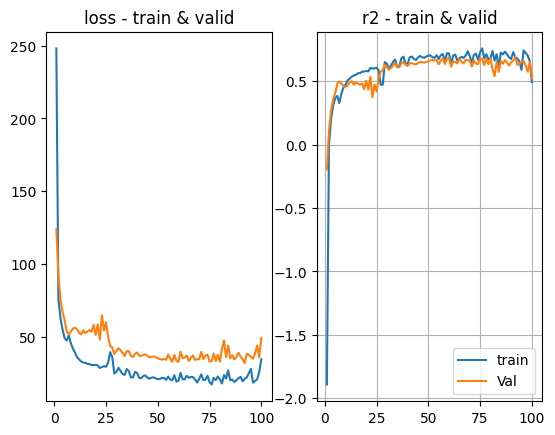

In [37]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

TRESHOLD=100
fg, axes=plt.subplots(1,2)
axes[0].plot(range(1,TRESHOLD+1), loss[0], label='train')
axes[0].plot(range(1,TRESHOLD+1), loss[1], label='Val')
axes[0].set_title('loss - train & valid')

axes[1].plot(range(1,TRESHOLD+1), r2[0], label='train')
axes[1].plot(range(1,TRESHOLD+1), r2[1], label='Val')
axes[1].set_title('r2 - train & valid')
plt.grid()
plt.legend()
plt.show()